### Volkswagen Data Time Series Analysis

In [1]:
# importing packages

import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [2]:
# importing data

raw_data = yfinance.download(tickers= "VOW3.DE, PAH3.DE, BMW.DE", interval='1d',group_by='ticker',
                             auto_adjust= True, threads=True)

[*********************100%***********************]  3 of 3 completed


In [5]:
df = raw_data.copy()
df.tail()

Ticker        PAH3.DE                                               VOW3.DE  \
Price            Open       High        Low      Close    Volume       Open   
Date                                                                          
2025-05-13  37.500000  38.230000  37.459999  38.090000  734901.0  96.302367   
2025-05-14  38.090000  38.090000  38.090000  38.090000       0.0  98.460136   
2025-05-15  38.029999  38.419998  37.840000  37.980000  656601.0  96.771449   
2025-05-16  37.980000  37.980000  37.980000  37.980000       0.0  97.568886   
2025-05-19  37.990002  38.299999  37.040001  37.290001  787877.0  97.000000   

Ticker                                                     BMW.DE             \
Price            High        Low      Close     Volume       Open       High   
Date                                                                           
2025-05-13  98.460136  95.880190  98.460136  1317113.0  82.400002  83.980003   
2025-05-14  98.460136  98.460136  98.460136        0.0  83.980003  83.980003   
2025-05-15  97.662701  96.536909  97.381256   798333.0  78.099998  78.919998   
2025-05-16  98.131782  95.833287  96.489998  1518948.0  77.680000  78.180000   
2025-05-19  98.620003  96.800003  97.500000  1444026.0  76.699997  77.720001   

Ticker                                     
Price             Low      Close   Volume  
Date                                       
2025-05-13  81.900002  83.980003  1510091  
2025-05-14  83.980003  83.980003        0  
2025-05-15  77.160004  77.580002  1229215  
2025-05-16  76.660004  76.919998  1029744  
2025-05-19  76.699997  77.559998   579046

In [6]:
# Defining Key Dates

# starting date
start_date = '2009-04-05'

# first official announcement 49.9%
ann_1 = '2009-12-09'

# second official announcement 50.1
ann_2 = '2012-07-05'

#ending date
end_date = '2014-01-01'

# dieselgate
d_gate = '2015-09-20'

#### Data Preprocessing

In [7]:
# extracting closing prices

df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# creating returns

df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# creating squared returns

df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# extracting volume

df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [8]:
# assigning frequency and the fill missing data

df = df.asfreq('b')
df = df.fillna(method='ffill')

In [9]:
# removing surplus data

del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

df.tail()

Ticker,vol,por,bmw,ret_vol,ret_por,ret_bmw,sq_vol,sq_por,sq_bmw,q_vol,q_por,q_bmw
Price,,,,,,,,,,,,
Date,,,,,,,,,,,,
2025-05-13,98.460136,38.090000,83.980003,3.756789,2.117965,3.017673,14.113467,4.485776,9.106349,1317113.0,734901.0,1510091.0
2025-05-14,98.460136,38.090000,83.980003,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2025-05-15,97.381256,37.980000,77.580002,-1.095753,-0.288791,-7.620864,1.200676,0.083400,58.077562,798333.0,656601.0,1229215.0
2025-05-16,96.489998,37.980000,76.919998,-0.915226,0.000000,-0.850739,0.837638,0.000000,0.723758,1518948.0,0.0,1029744.0
2025-05-19,97.500000,37.290001,77.559998,1.046743,-1.816742,0.832033,1.095671,3.300552,0.692278,1444026.0,787877.0,579046.0


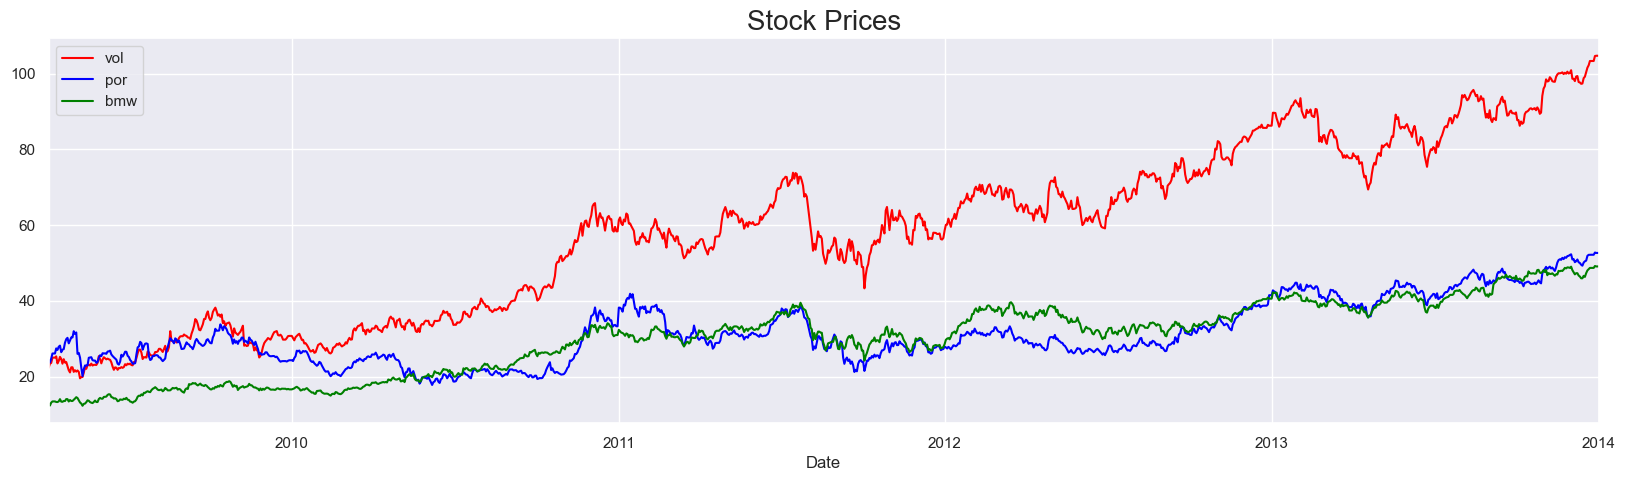

In [11]:
# plotting stock price data

df['vol'][start_date:end_date].plot(figsize=(20,5),color = 'red')
df['por'][start_date:end_date].plot(color = 'blue')
df['bmw'][start_date:end_date].plot(color = 'green')
plt.title('Stock Prices', size=20)
plt.legend()
plt.show()